In [25]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_tunneling.workflows import run_bound_states, run_field_scan
from quantum_tunneling.fields import apply_field, barrier_top


import matplotlib.animation as animation

In [26]:
potentials = {
    "cusp": {"kind": "cusp", "params": {"V0": 10.0, "alpha": 0.5}},
    "exp_well": {"kind": "exp_well", "params": {"V0": 5.0, "a": 1.0}},
    "soft_barrier": {"kind": "soft_barrier", "params": {"V0": 5.0}},
    "rough": {"kind": "rough", "params": {"V0": 1.0, "k0": 0.6, "levels": 4, "decay": 0.6}},
}
pot_key = "cusp"
state_index = 0
F_grid = np.linspace(0.8, 2, 20)
cfg = {
    "potential": potentials[pot_key],
    "grid": {"L": 50.0, "N": 1200},
    "solver": {"k": 6, "hbar": 1.0, "m": 1.0},
}
cfg

{'potential': {'kind': 'cusp', 'params': {'V0': 10.0, 'alpha': 0.5}},
 'grid': {'L': 50.0, 'N': 1200},
 'solver': {'k': 6, 'hbar': 1.0, 'm': 1.0}}

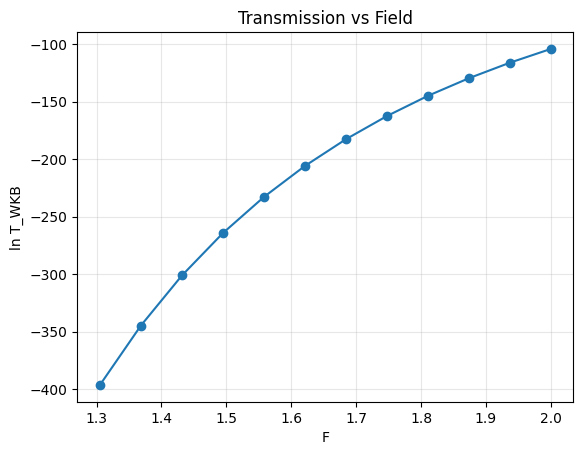

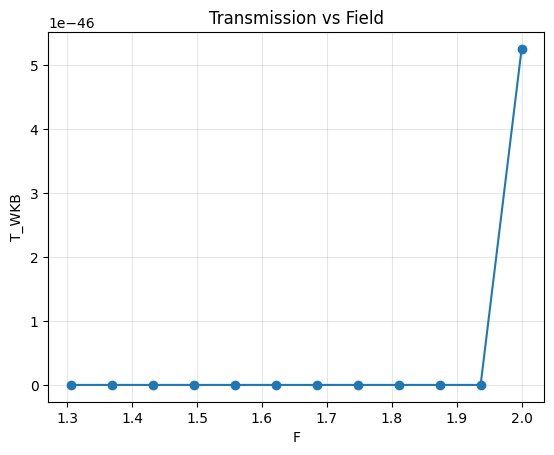

{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (39.09242298084929, 31.249995417384948, 1069), 'F': 0.8}
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (33.513738551207325, 28.963403585365416, 1002), 'F': 0.8631578947368421}
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (29.100749375520394, 26.988626781692343, 949), 'F': 0.9263157894736842}
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (25.520399666944215, 25.265955452881336, 906), 'F': 0.9894736842105264}
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (22.522897585345547, 23.7499816914516, 870), 'F': 1.0526315789473686}
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (20.10824313072439, 22.40564972714206, 841), 'F': 1.1157894736842104}
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_top': (18.026644462947544, 21.205331009207523, 816), 'F': 1.1789473684210527}
{'status': 'no_closed_barrier', 'barrier': False, 'barrier_

In [27]:
res = run_bound_states(cfg)
scan = run_field_scan(cfg, res, state_index=state_index, F_grid=F_grid)
records = scan['records']
F_vals = [r['F'] for r in records]
T = [r['T_wkb'] if 'T_wkb' in r else (1 if r['status'] == "over_the_barrier" else np.nan) for r in records]
lnT = np.log(T)
plt.figure()
plt.plot(F_vals, lnT, marker='o')
plt.xlabel('F')
plt.ylabel('ln T_WKB')
plt.title('Transmission vs Field')
plt.grid(True, alpha=0.3)
plt.savefig('transmission_vs_field_for_ground_state.png')
plt.figure()
plt.plot(F_vals, T, marker='o')
plt.xlabel('F')
plt.ylabel('T_WKB')
plt.title('Transmission vs Field')
plt.grid(True, alpha=0.3)
plt.show()


for r in records:
    print(r)

T_wkb都这么小。我觉得应该是m=1导致接近经典版本（毕竟经典隧穿概率为0）

不对应该不是，因为前面有个1/hbar

# How exotic barriers deform under tilting?
# 奇异势垒在倾斜下如何变形的？
我们对Vcusp施加一个线性外场F*x，扫描一系列场强F，然后创建势能图像的动画，这就能帮助我们理解势垒在外场下的变形情况。

0.8 39.09242298084929 31.249995417384948
0.8 39.09242298084929 31.249995417384948
0.8631578947368421 33.513738551207325 28.963403585365416
0.9263157894736842 29.100749375520394 26.988626781692343
0.8631578947368421 33.513738551207325 28.963403585365416
0.9263157894736842 29.100749375520394 26.988626781692343
0.9894736842105264 25.520399666944215 25.265955452881336
1.0526315789473686 22.522897585345547 23.7499816914516
0.9894736842105264 25.520399666944215 25.265955452881336
1.0526315789473686 22.522897585345547 23.7499816914516
1.1157894736842104 20.10824313072439 22.40564972714206
1.1789473684210527 18.026644462947544 21.205331009207523
1.1157894736842104 20.10824313072439 22.40564972714206
1.1789473684210527 18.026644462947544 21.205331009207523
1.2421052631578948 16.194837635303912 20.127117022114657
1.305263157894737 14.696086594504578 19.15321481131819
1.2421052631578948 16.194837635303912 20.127117022114657
1.305263157894737 14.696086594504578 19.15321481131819
1.368421052631579 

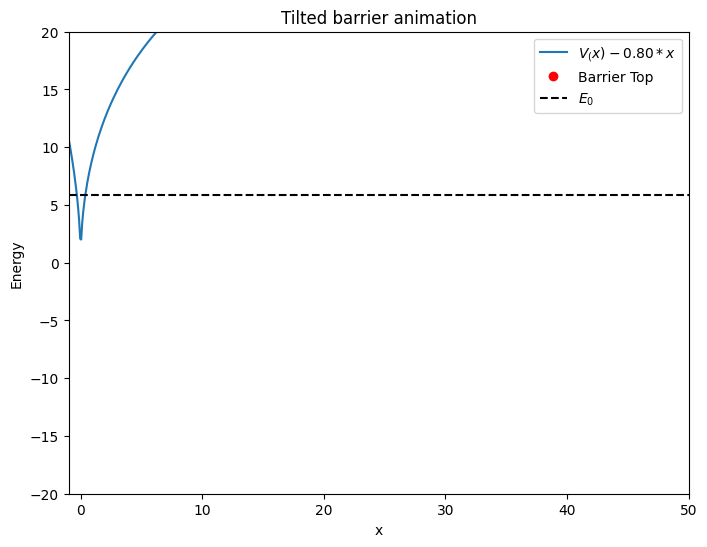

In [31]:
# Visualize tilted barriers at a few F values.
'''sample_F = [F_vals[0], F_vals[len(F_vals)//2], F_vals[-1]]
x = res['x']
E = res['E'][state_index]
for F in sample_F:
    Vtilt = apply_field(res['Vx'], x, F)
    plt.figure()
    plt.plot(x, Vtilt, label=f'V-Fx (F={F:.2f})')
    plt.axhline(E, color='k', linestyle='--', label='E')
    plt.xlabel('x')
    plt.ylabel('Energy')
    plt.legend()
    plt.title('Tilted barrier snapshot')
    plt.tight_layout()
    plt.show()
    '''
# Visualize tilted barriers as an animation over F values.
x = res['x']
E = res['E'][state_index]
fig, ax = plt.subplots(figsize=(8, 6))
def update(frame):
    ax.cla()
    ax.set_ylim(-20, 20)
    ax.set_xlim(-1, cfg["grid"]["L"])
    F = F_vals[frame]
    Vtilt = apply_field(res['Vx'], x, F)
    idx = barrier_top(x, Vtilt,x_min=0)
    xtop, vtop = x[idx], Vtilt[idx]
    print(F, xtop, vtop)
    ax.plot(x, Vtilt, label=f'$V_(x)-{F:.2f}*x$')
    ax.plot(xtop, vtop, 'ro', label='Barrier Top')
    ax.axhline(E, color='k', linestyle='--', label='$E_0$')
    ax.set_xlabel('x')
    ax.set_ylabel('Energy')
    ax.legend()
    ax.set_title('Tilted barrier animation')
ani = animation.FuncAnimation(fig, update, frames=len(F_vals), repeat=False)
ani.save('tilted_barrier_animation.gif', writer='pillow', fps=10)

# Discussion

![Transmission vs Field](transmission_vs_field_for_ground_state.png)
![Tilted Barrier Animation](tilted_barrier_animation.gif)

As the external field strength increases, the exotic barrier gradually tilts, lowering the barrier height on the right side. This results in a decrease in the action integral $S=\int_{x_1}^{x_2} \sqrt{2m(V(x)-E)}\,dx$ and a corresponding increase in the WKB transmission coefficient $T=\exp(-\frac{2}{\hbar}S)$. The turning points move closer together as the barrier becomes less pronounced, facilitating tunneling.

When the field strength reaches a critical value, the barrier top drops below the bound state energy level (ground state in this case). At this point, the concept of tunneling becomes less relevant, as the particle can effectively escape without tunneling.

In [29]:

def F_ionization(V0,alpha,En):
    b = 1 - alpha
    return alpha*(b**b*V0/(En**b))**(1/alpha)

print("Estimated ionization field:", F_ionization(5,0.5, res['E'][0]))

Estimated ionization field: 1.0678301283634481


# Onset of over-the-barrier ionization

### Result

For tilt Vcusp, the onset of over-the-barrier escape occurs at $F_{ionization}(V_0, \alpha, E_n) = \alpha \left( \frac{(1-\alpha)^{(1-\alpha)} V_0}{ E_n^{(1-\alpha)}} \right)^{1/\alpha}$.

### Deduction

$$
V(x) = V_0 |x|^\alpha + F x
$$

We take the part that x>0 for simplicity. The barrier top occurs where the derivative is zero:

$$
\frac{dV}{dx} = \alpha V_0 x^{\alpha - 1} + F = 0
$$

Solving for x gives the barrier top position:

$$
x_{top} = \left(-\frac{F}{\alpha V_0}\right)^{\frac{1}{\alpha - 1}}
$$

Plugging this back into V(x) to find the barrier height, and setting it equal to the energy level E_n:

$$
V_{top} = V_0 \left(-\frac{F}{\alpha V_0}\right)^{\frac{\alpha}{\alpha - 1}} + F \left(-\frac{F}{\alpha V_0}\right)^{\frac{1}{\alpha - 1}} = E_n
$$

Solving this equation for F gives the ionization field strength:

$$
F_{ionization} = \alpha \left( \frac{(1-\alpha)^{(1-\alpha)} V_0}{ E_n^{(1-\alpha)}} \right)^{1/\alpha}
$$

State n=0, E=5.8530, F_ionization=1.0678
State n=1, E=10.0612, F_ionization=0.6212
State n=2, E=12.1322, F_ionization=0.5152
State n=3, E=13.9910, F_ionization=0.4467
State n=4, E=15.3911, F_ionization=0.4061
State n=5, E=16.7317, F_ionization=0.3735


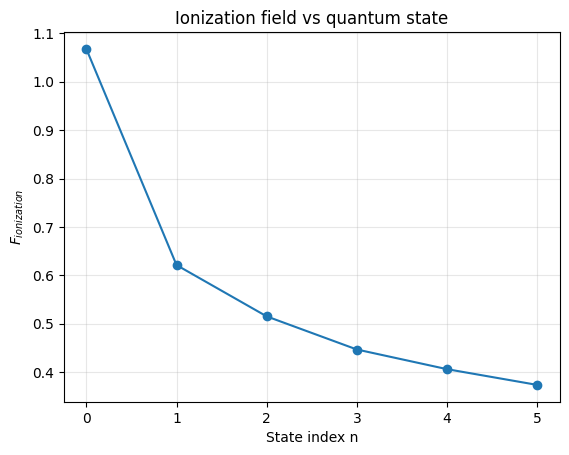

In [30]:
# 分析不同激发态的ionization field
F_ion_list = []
for n in range(cfg["solver"]["k"]):
    F_ion = F_ionization(5, 0.5, res['E'][n])
    F_ion_list.append(F_ion)
    print(f"State n={n}, E={res['E'][n]:.4f}, F_ionization={F_ion:.4f}")

# 画出 F_ionization vs state_index，看看趋势
plt.figure()
plt.plot(range(len(F_ion_list)), F_ion_list, marker='o')
plt.xlabel('State index n')
plt.ylabel('$F_{ionization}$')
plt.title('Ionization field vs quantum state')
plt.grid(True, alpha=0.3)
plt.show()